## Import relevant packages

In [19]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import *
from sklearn.model_selection import *
from sklearn.preprocessing import *
from sklearn.pipeline import *

from sklearn.linear_model import *
from sklearn.ensemble import *
from scipy.stats import *

from sklearn.metrics import *

from xgboost import *


## Import dataset
Extract dataset from https://www.kaggle.com/datasets/ziya07/drugpatient-dataset-for-ckd-prediction?resource=download

In [20]:
data = pd.read_csv("data/CKD_NephrotoxicDrug_Dataset.csv")
pd.set_option('display.max_columns', None) 
print(data.head())              # display first 5 rows
print(data.info())              # summary of the data
print(data.isnull().sum())      # number of missing values for each column

   patient_age  gender  bp_systolic  bp_diastolic  blood_urea  \
0           69    Male        136.5          90.4        45.3   
1           32    Male        125.0          62.6        22.4   
2           89  Female        124.2          71.1        36.0   
3           78    Male         98.7          81.6         4.7   
4           38    Male        147.7          81.4        56.6   

   serum_creatinine  albumin  blood_glucose_random  diabetes  hypertension  \
0              1.42        2                 175.2         0             1   
1              0.66        0                 138.0         0             0   
2              1.72        0                 177.2         0             0   
3              0.34        0                 121.6         0             0   
4              1.39        0                  65.4         0             1   

    drug_name  drug_dosage_mg  exposure_days  nephrotoxic_label  mol_weight  \
0  Gentamicin              83             14                 

In [21]:
for i in data.columns:
    print(i, ":", data[i].nunique()) # number of unique values for each column

patient_age : 72
gender : 2
bp_systolic : 665
bp_diastolic : 474
blood_urea : 557
serum_creatinine : 283
albumin : 4
blood_glucose_random : 938
diabetes : 2
hypertension : 2
drug_name : 8
drug_dosage_mg : 636
exposure_days : 29
nephrotoxic_label : 2
mol_weight : 1463
logP : 551
hbond_donors : 8
hbond_acceptors : 11
rotatable_bonds : 10
tpsa : 1395
shape_index_3d : 81
inertia_x : 769
inertia_y : 784
inertia_z : 763
charge_distribution : 91
clearance_rate : 670
half_life_hr : 669
bioavailability_pct : 1360
volume_of_distribution : 131
kidney_cell_viability_pct : 646
mitochondrial_damage : 91
oxidative_stress : 91
protein_binding_pct : 672
serum_creatinine_change_pct : 1238
toxicity_score_composite : 194
pk_toxic_interaction_score : 93
ckd_risk_label : 3


The dataset has 37 columns and 1500 rows with no missing values. There are only 2 columns with string variables, gender and drug_name. Variables were classified as categorical or numerical based on their semantic meaning rather than solely on the number of unique values. Categorical variables (gender, diabetes, hypertension, drug_name, nephrotoxic_label, and ckd_risk_label) represent discrete labels or clinical states for which numerical operations are not meaningful. All remaining variables were treated as numerical as they represent continuous measurements or count-based quantities with an inherent order and magnitude, even when the number of unique values is relatively small. This approach preserves interpretability and allows meaningful statistical analysis and model learning.

## Exploratory Data Analysis
This section explores the distributions and visual patterns of the dataset to examine relationships between feature variables and the target variable, ckd_risk_label. Due to the relatively high number of features (37 variables), univariate statistical tests were first conducted to screen for variables significantly associated with CKD risk. Statistically significant features were subsequently explored through visualisation to assess distributional differences across CKD risk groups.

For the purpose of analysis, individuals were grouped based on CKD risk status. Categorical variables were evaluated using the chi-square test, while numerical continuous variables were assessed using the t-test.

### Data Overview
An overview of the dataset was first examined by visualising the distribution of CKD risk levels. The dataset shows a higher proportion of individuals in the moderate CKD risk category compared to the low and high risk groups.

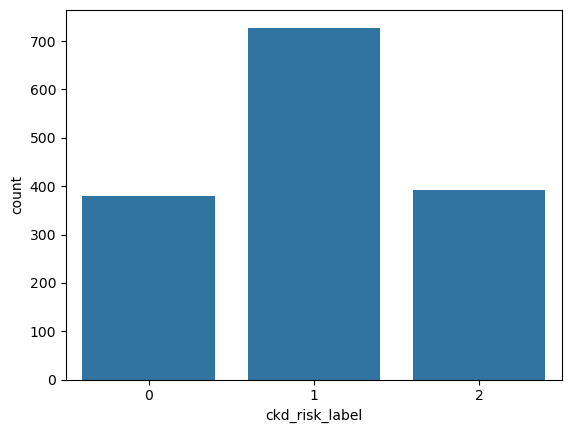

In [22]:
sns.countplot(data=data, x="ckd_risk_label")
plt.show()

In [23]:
# Change these specific columns to categorical since they have discrete number of unique values
for i in ['gender','drug_name','diabetes','hypertension', 'nephrotoxic_label', 'ckd_risk_label']:
    data[i] = data[i].astype('category')
print(data.dtypes)

patient_age                       int64
gender                         category
bp_systolic                     float64
bp_diastolic                    float64
blood_urea                      float64
serum_creatinine                float64
albumin                           int64
blood_glucose_random            float64
diabetes                       category
hypertension                   category
drug_name                      category
drug_dosage_mg                    int64
exposure_days                     int64
nephrotoxic_label              category
mol_weight                      float64
logP                            float64
hbond_donors                      int64
hbond_acceptors                   int64
rotatable_bonds                   int64
tpsa                            float64
shape_index_3d                  float64
inertia_x                       float64
inertia_y                       float64
inertia_z                       float64
charge_distribution             float64


### Statistical Tests
Univariate statistical tests were conducted to identify feature variables significantly associated with CKD risk. These tests informed the selection of features for subsequent visual exploration.

In [24]:
# Split data
data_noCKDrisk = data[data['ckd_risk_label']==0]
data_CKDrisk = data[data['ckd_risk_label'].isin([1,2])]


In [25]:
# t-test for numerical columns
for i in list(data.columns):
    if i not in ['gender','drug_name','diabetes','hypertension', 'nephrotoxic_label', 'ckd_risk_label']:
        stat, p = ttest_ind(data_noCKDrisk[i], data_CKDrisk[i], equal_var=False)
        significance = "Significant" if p < 0.05 else "Not significant"
        print(f"{i}: p-value = {p:.4f}, {significance}")

patient_age: p-value = 0.0576, Not significant
bp_systolic: p-value = 0.7819, Not significant
bp_diastolic: p-value = 0.6033, Not significant
blood_urea: p-value = 0.0000, Significant
serum_creatinine: p-value = 0.0000, Significant
albumin: p-value = 0.0140, Significant
blood_glucose_random: p-value = 0.3282, Not significant
drug_dosage_mg: p-value = 0.2373, Not significant
exposure_days: p-value = 0.8964, Not significant
mol_weight: p-value = 0.6560, Not significant
logP: p-value = 0.2293, Not significant
hbond_donors: p-value = 0.0708, Not significant
hbond_acceptors: p-value = 0.8833, Not significant
rotatable_bonds: p-value = 0.9729, Not significant
tpsa: p-value = 0.7225, Not significant
shape_index_3d: p-value = 0.0441, Significant
inertia_x: p-value = 0.9441, Not significant
inertia_y: p-value = 0.4438, Not significant
inertia_z: p-value = 0.1542, Not significant
charge_distribution: p-value = 0.0475, Significant
clearance_rate: p-value = 0.8641, Not significant
half_life_hr: p-

There are 10 statistically significant numerical columns: blood_urea, serum_creatinine, albumin, shape_index_3d, charge_distribution, kidney_cell_viability_pct, mitochondrial_damage, oxidative_stress, serum_creatinine_change_pct, toxicity_score_composite.

In [26]:
# chi-square test for numerical columns
for i in list(data.columns):
    if i in ['gender','drug_name','diabetes','hypertension', 'nephrotoxic_label']:
        table = pd.crosstab(data[i], data['ckd_risk_label'])  # contingency table
        chi2, p, dof, expected = chi2_contingency(table)
        significance = "Significant" if p < 0.05 else "Not significant"
        print(f"{i}: p-value = {p:.4f}, {significance}")

gender: p-value = 0.6943, Not significant
diabetes: p-value = 0.0000, Significant
hypertension: p-value = 0.0000, Significant
drug_name: p-value = 0.0000, Significant
nephrotoxic_label: p-value = 0.0000, Significant


There are 4 statistically significant categorical columns: diabetes, hypertension, drug_name, nephrotoxic_label.

### Plots

#### Numerical Variables
Out of 10 statistically significant numerical variables, 5 had p-values less than 0.00001. Among these, blood_urea and serum_creatinine are clinical factors, while the remaining 3 are drug-related variables that measure changes in kidney function following drug exposure. These 5 variables were subsequently plotted to visualize their distributions and to examine their relationships with the target variable, risk of CKD.

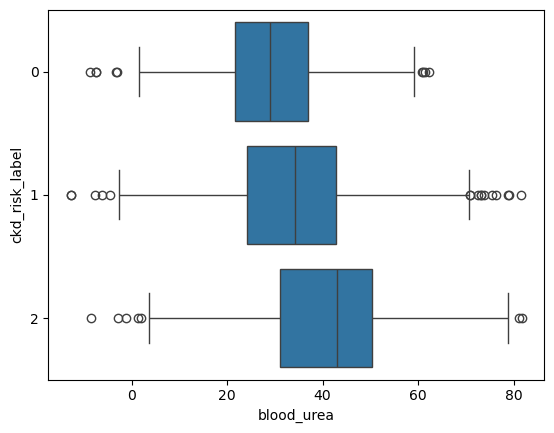

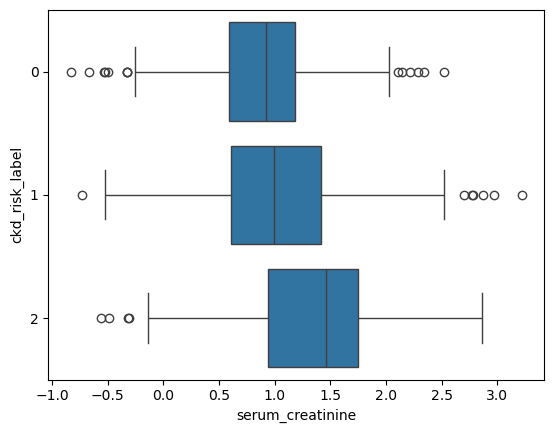

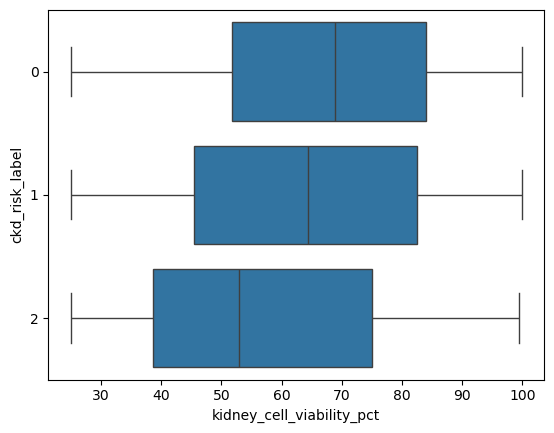

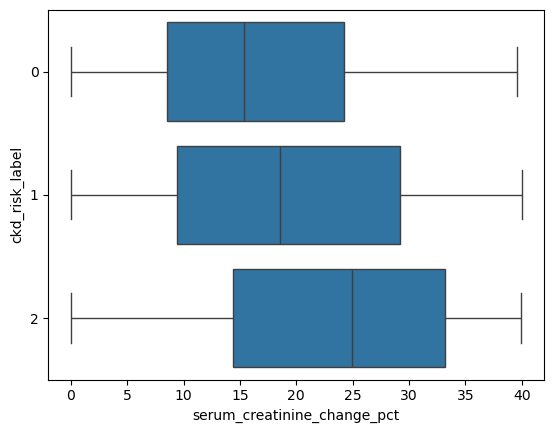

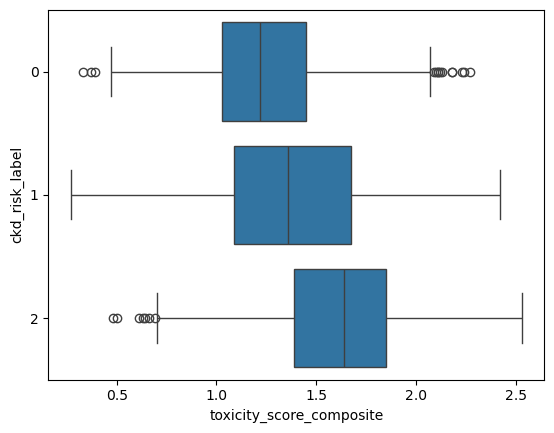

In [27]:
# Boxplot of the 5 chosen numerical variables
for i in ["blood_urea", "serum_creatinine", "kidney_cell_viability_pct", "serum_creatinine_change_pct", "toxicity_score_composite"]:
    sns.boxplot(x=i, y="ckd_risk_label", data=data)
    plt.show()

The 5 boxplots show a clear shift in the median values of the numerical variables across different CKD risk levels. Blood_urea and serum_creatinine exhibit significant outliers. Individuals with higher CKD risk exhibit higher median blood urea and serum creatinine levels, reflecting poorer kidney function. In contrast, higher CKD risk is associated with lower median kidney cell viability and higher median serum creatinine change and composite drug toxicity score following drug exposure. These trends suggest that both clinical biomarkers and drug-related toxicity measures are strongly associated with increased CKD risk.

#### Categorical Variables
Out of 4 statistically significant categorical variables, all 4 of them have p-value less than 0.00001. Out of these, diabetes and hypertension are clinical factors while the remaining two are drug-related factors. These 4 variables were subsequently plotted to visualize their distributions and to examine their relationships with the target variable, risk of CKD.

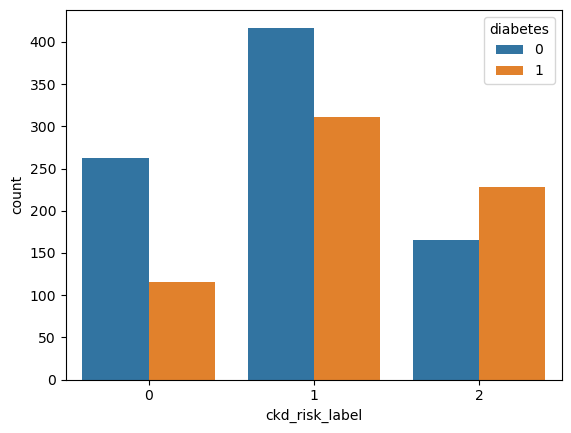

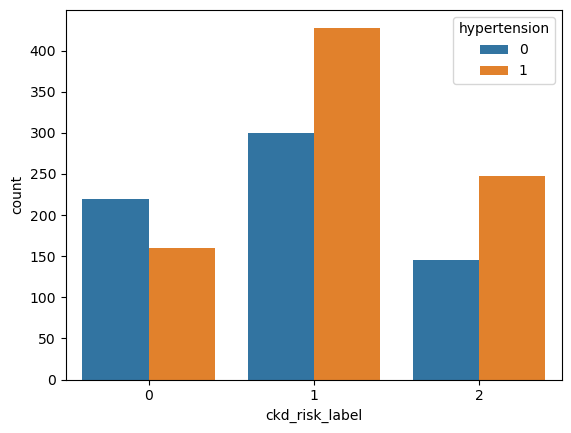

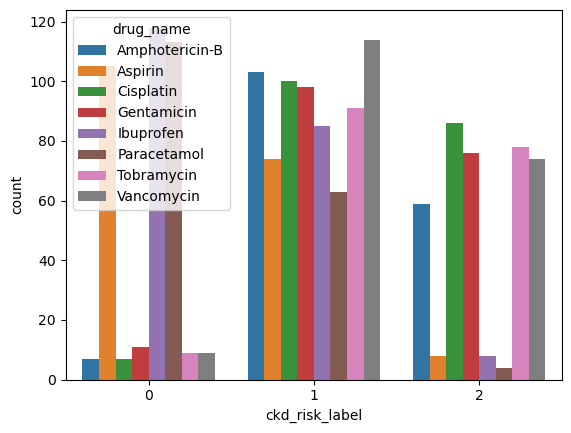

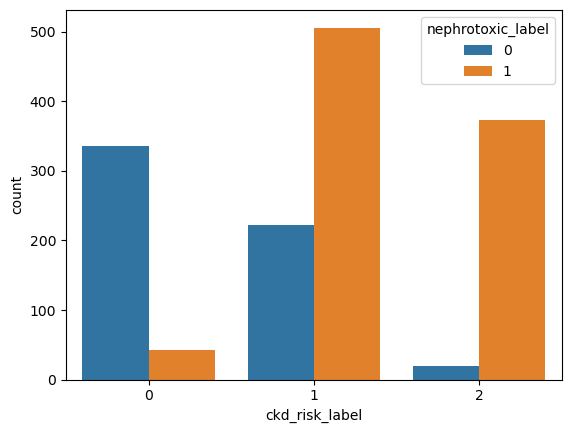

In [28]:
# Barplot of the 4 chosen categorical variables
for i in ["diabetes", "hypertension", "drug_name", "nephrotoxic_label"]:
    sns.countplot(data=data, x="ckd_risk_label", hue=i)
    plt.show()

Although the number of individuals in the moderate CKD risk group is higher than those in the high-risk group, this reflects the underlying distribution of CKD risk levels in the dataset. Despite this class imbalance, clear trends are observed across the categorical variables. As CKD risk increases, a higher proportion of individuals have diabetes and hypertension. Additionally, higher CKD risk is associated with a greater proportion of individuals who were administered Amphotericin B, Cisplatin, Gentamicin, Tobramycin, and Vancomycin, as well as drugs labeled as nephrotoxic.

### Feature Importance
Based on univariate statistical testing and exploratory visualisation, nine numerical features were identified as significantly associated with CKD risk. Among these, blood urea, serum creatinine, kidney cell viability percentage, serum creatinine change, and the composite toxicity score exhibited the strongest and most consistent trends across CKD risk levels and were therefore highlighted as particularly informative. Additional drug-related numerical features, including shape index, charge distribution, mitochondrial damage, and oxidative stress, also showed statistically significant associations with CKD risk.

Analysis of categorical variables further indicated that existing medical conditions such as diabetes and hypertension, as well as exposure to nephrotoxic drugs and particular drugs such as Amphotericin B, Cisplatin, Gentamicin, Tobramycin, and Vancomycin, were associated with higher CKD risk levels.

While all features were retained for modeling, these findings provided guidance on which variables are likely to contribute more strongly to CKD risk prediction and informed subsequent preprocessing and model development.

## Pre-processing
The dataset was prepared for modeling by converting string categorical variables (e.g., gender, drug_name) into numeric dummy variables, while binary categorical variables already represented as 0/1 (e.g., diabetes, hypertension, nephrotoxic_label) were converted to integer type and left unchanged.

In [29]:
# One-hot encoding
data_cleaned = pd.get_dummies(data, columns=['gender','drug_name'], drop_first=False, dtype=int)

encoded_cols = [col for col in data_cleaned.columns if 'gender' in col or 'drug_name' in col]
data_cleaned[encoded_cols].head()

,gender_Female,gender_Male,drug_name_Amphotericin-B,drug_name_Aspirin,drug_name_Cisplatin,drug_name_Gentamicin,drug_name_Ibuprofen,drug_name_Paracetamol,drug_name_Tobramycin,drug_name_Vancomycin
0,0,1,0,0,0,1,0,0,0,0
1,0,1,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0,0,1,0,0,0
4,0,1,0,1,0,0,0,0,0,0


In [30]:
# change binary columns to integer types
binary_cols = ['diabetes', 'hypertension', 'nephrotoxic_label']
data_cleaned[binary_cols] = data_cleaned[binary_cols].astype(int)

## Machine Learning Models
The dataset was separated into feature variables and the target variable, CKD risk.
Stratified k-fold cross-validation was used for model evaluation, where in each fold approximately 80% of the data was used for training and 20% for testing, while preserving the class distribution of CKD risk levels.
Within each cross-validation iteration, a modelling pipeline was applied in which numerical features were first standardised only for Logistic Regression, followed by model fitting on the training set and evaluation on the held-out test set.

To address class imbalance in CKD risk levels, stratified k-fold cross-validation was used to preserve the distribution of each risk category in training and test folds. Additionally, the model was trained with class_weight='balanced' to penalize misclassification of minority classes, ensuring that high-risk individuals were given appropriate importance during learning. This approach improves recall for underrepresented classes while maintaining overall predictive performance.

In healthcare risk prediction, recall is often prioritised to minimise Type II errors, as failing to identify high-risk individuals can have severe clinical consequences. Precision remains important to avoid excessive false alarms, while the F1 score provides a balanced assessment of both precision and recall. ROC AUC is reported to evaluate the model’s overall discriminatory ability across classification thresholds.

In [31]:
# Stratified k-fold CV split of dataset
X = data_cleaned.drop(columns='ckd_risk_label')
y = data_cleaned['ckd_risk_label']

skf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

### Logistic Regression
Logistic Regression was chosen as a baseline model due to its simplicity, interpretability, and suitability for multi-class classification of CKD risk. It provides probabilistic outputs, allowing for threshold adjustment and easy interpretation of feature importance. In addition, Logistic Regression can incorporate class weighting to handle imbalanced CKD risk levels, making it appropriate for healthcare risk prediction tasks where recall is critical. Numerical features were scaled prior to modelling, as Logistic Regression is a linear model whose coefficients and optimisation are sensitive to feature magnitudes.

In [32]:
pipe_lr = Pipeline([
    ('scale', StandardScaler()),
    ('model', LogisticRegression(
        class_weight='balanced'
    ))
])

scoring = {
    'accuracy': 'accuracy',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro',
    'f1_macro': 'f1_macro',
    'roc_auc_ovr': 'roc_auc_ovr'
}

cv_results_lr = cross_validate(
    pipe_lr,
    X,
    y,
    cv=skf,
    scoring=scoring
)

pd.DataFrame(cv_results_lr).mean()

fit_time                0.018649
score_time              0.016102
test_accuracy           0.777333
test_precision_macro    0.773499
test_recall_macro       0.798874
test_f1_macro           0.782545
test_roc_auc_ovr        0.922811
dtype: float64

Accuracy and precision are both around 0.78, while recall is slightly higher at 0.80, indicating that the Logistic Regression model effectively identifies high-risk CKD cases while maintaining reasonable control of false positives. The F1 score of 0.79 highlights a balanced trade-off between precision and recall. A high ROC AUC of approximately 0.92 demonstrates strong overall discriminatory ability, showing that the model can distinguish between different CKD risk levels across thresholds while keeping both false negatives and false positives relatively low.

### Random Forest
Random Forest was chosen due to its ability to handle high-dimensional data, capture complex nonlinear relationships, and provide inherent feature importance measures. Its ensemble of decision trees reduces overfitting compared to single-tree models, and it can natively handle imbalanced datasets through class weighting. This makes Random Forest well-suited for predicting CKD risk, where interactions between clinical and drug-related features may be complex and non-linear.

In [33]:
pipe_rf = Pipeline([
    ('model', RandomForestClassifier(
        class_weight='balanced',
    ))
])

scoring = {
    'accuracy': 'accuracy',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro',
    'f1_macro': 'f1_macro',
    'roc_auc_ovr': 'roc_auc_ovr'
}

cv_results_rf = cross_validate(
    pipe_rf,
    X,
    y,
    cv=skf,
    scoring=scoring
)

pd.DataFrame(cv_results_rf).mean()

fit_time                0.355106
score_time              0.020097
test_accuracy           0.869333
test_precision_macro    0.901159
test_recall_macro       0.847526
test_f1_macro           0.866841
test_roc_auc_ovr        0.965762
dtype: float64

Random Forest outperformed Logistic Regression across all evaluation metrics. Accuracy increased to 0.87, with precision of approximately 0.90 and recall of 0.84, indicating improved identification of high-risk CKD cases while better controlling false positives. The F1 score of 0.86 reflects a stronger balance between precision and recall compared to the baseline model. A high ROC AUC of approximately 0.96 further demonstrates superior discriminatory ability across CKD risk levels.

### XGBoost
XGBoost was chosen for its powerful gradient boosting framework, which builds an ensemble of decision trees sequentially, with each tree focusing on correcting the errors of the previous ones. This allows XGBoost to capture complex non-linear relationships and interactions between features more effectively than independent tree models. With built-in regularization, handling of missing values, and support for imbalanced datasets through class weighting, XGBoost provides strong predictive performance, making it particularly suitable for accurately identifying high-risk CKD cases in a healthcare dataset.

In [36]:
binary_cols = ['diabetes', 'hypertension', 'nephrotoxic_label']
data_cleaned[binary_cols] = data_cleaned[binary_cols].astype(int)

X = data_cleaned.drop(columns='ckd_risk_label')
y = data_cleaned['ckd_risk_label']

skf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

pipe_xg = Pipeline([
    ('model', XGBClassifier(
        objective='multi:softprob',
        num_class=3,
    ))
])

scoring = {
    'accuracy': 'accuracy',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro',
    'f1_macro': 'f1_macro',
    'roc_auc_ovr': 'roc_auc_ovr'
}


cv_results_xg = cross_validate(
    pipe_xg,
    X,
    y,
    cv=skf,
    scoring=scoring
)

pd.DataFrame(cv_results_xg).mean()

fit_time                0.245954
score_time              0.016108
test_accuracy           0.987333
test_precision_macro    0.988101
test_recall_macro       0.986773
test_f1_macro           0.987393
test_roc_auc_ovr        0.998307
dtype: float64

XGBoost outperformed all previous models across every evaluation metric. Accuracy, precision, recall, and F1 score all reached approximately 0.99, indicating improved identification of high-risk CKD cases while effectively controlling false positives and maintaining a strong balance between precision and recall compared to the baseline models. The ROC AUC of around 0.998 further demonstrates its superior discriminatory ability across CKD risk levels.

## Feature Selection
Since XGBoost achieved the highest performance across all evaluation metrics, it was further trained and evaluated using the key features identified during exploratory data analysis. These included clinical variables (diabetes, hypertension, nephrotoxic_label), core kidney function measures (blood_urea, serum_creatinine, kidney_cell_viability_pct, serum_creatinine_change_pct, toxicity_score_composite), and drug-related features captured through one-hot encoding of drug_name.

In [38]:
selected_features = [
    "diabetes", "hypertension", "nephrotoxic_label",
    "blood_urea", "serum_creatinine", "kidney_cell_viability_pct",
    "serum_creatinine_change_pct", "toxicity_score_composite"
]
encoded_features = [col for col in data_cleaned.columns if 'drug_name' in col]
top_features = selected_features + encoded_features

X_top = data_cleaned[top_features]
y = data_cleaned['ckd_risk_label']

pipe_xgb_top = Pipeline([
    ('model', XGBClassifier(
        objective='multi:softprob',
        num_class=3,
    ))
])

cv_results_top = cross_validate(pipe_xgb_top, X_top, y, cv=skf, scoring=scoring)
pd.DataFrame(cv_results_top).mean()

fit_time                0.139461
score_time              0.012822
test_accuracy           0.988667
test_precision_macro    0.990776
test_recall_macro       0.986816
test_f1_macro           0.988641
test_roc_auc_ovr        0.999345
dtype: float64

The model achieved near-perfect performance across all evaluation metrics. Importantly, the inclusion of only the top features did not lead to overfitting and in fact the reduced feature set improved all metrics. This demonstrates that the features identified during EDA are the most informative, highlighting which clinical and drug-related variables contribute most to CKD risk. These insights can help guide clinical decision-making by prioritising the monitoring of high-risk biomarkers and drug exposures in patients.

## Evaluation

In [41]:
# Table of comparison
df_lr = pd.DataFrame(cv_results_lr).mean().rename('Logistic Regression')
df_rf = pd.DataFrame(cv_results_rf).mean().rename('Random Forest')
df_xg = pd.DataFrame(cv_results_xg).mean().rename('XGBoost (all features)')
df_xg_top = pd.DataFrame(cv_results_top).mean().rename('XGBoost (top features)')

summary_table = pd.concat([df_lr, df_rf, df_xg, df_xg_top], axis=1)

summary_table

,Logistic Regression,Random Forest,XGBoost (all features),XGBoost (top features)
fit_time,0.018649,0.355106,0.245954,0.139461
score_time,0.016102,0.020097,0.016108,0.012822
test_accuracy,0.777333,0.869333,0.987333,0.988667
test_precision_macro,0.773499,0.901159,0.988101,0.990776
test_recall_macro,0.798874,0.847526,0.986773,0.986816
test_f1_macro,0.782545,0.866841,0.987393,0.988641
test_roc_auc_ovr,0.922811,0.965762,0.998307,0.999345


Out of all the models, XGBoost performed the best across all evaluation metrics, effectively reducing Type I and Type II errors, which are crucial in disease prediction. It also achieved the highest ROC AUC, demonstrating strong discriminatory ability to correctly classify CKD risk levels. XGBoost uses boosting, whereas Random Forest uses bagging; combined with regularization, this helps XGBoost achieve higher performance and avoid overfitting. Both tree-based models outperformed the baseline Logistic Regression, as they can capture nonlinear relationships and correlations between features that a linear model cannot. However, feature importance is not immediately interpretable in tree-based models, emphasizing the value of exploratory analysis. By re-evaluating XGBoost using the top identified features, we confirmed that the model was not overfitted and could highlight which factors contribute most to CKD risk. The top features, diabetes, hypertension, nephrotoxic_label, blood_urea, serum_creatinine, kidney_cell_viability_pct, serum_creatinine_change_pct, and toxicity_score_composite, demonstrated that both clinical and drug-related variables significantly influence CKD risk, supporting better clinical decision-making when prescribing medications to patients with specific conditions.